# Optimise_Task 2

In [1]:
#!pip install numpy pandas matplotlib seaborn scikit-learn

In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import geopandas as gpd
import folium
import osmnx as ox
from shapely.geometry import Point

In [2]:
df = pd.read_csv(r'D:\BIG_DATA\external_data\optimise_task2.csv')

In [3]:
df.head()

,Unnamed: 0,gpsLat,gpsLong,type,physicalPosition,session.averagePower,session.creationTime,session.creationTime.1,session.type,session.position,carChargeParameter.maxPower,carChargeParameter.current,numberStacks,chargerId
0,0,43.075102,13.842823,CCS2_400,4.0,NaN,2024-07-14T06:01:27.461303+00:00,2024-07-14T06:01:27.461303+00:00,NaN,2,0.0,500.0,4.0,13418.0
1,1,44.518340,11.214320,CCS2_400,4.0,NaN,2024-07-14T06:01:29.119003+00:00,2024-07-14T06:01:29.119003+00:00,NaN,2,0.0,200.0,4.0,8118.0
2,2,41.891882,12.758657,CCS2_400,1.0,NaN,2024-07-14T06:01:58.304994+00:00,2024-07-14T06:01:58.304994+00:00,NaN,1,0.0,500.0,4.0,13448.0
3,3,46.206436,13.048325,CCS2_400,1.0,NaN,2024-07-14T06:03:00.278437+00:00,2024-07-14T06:03:00.278437+00:00,NaN,1,0.0,500.0,4.0,19528.0
4,4,45.729300,9.029120,CCS2_400,4.0,NaN,2024-07-14T06:03:25.545657+00:00,2024-07-14T06:03:25.545657+00:00,NaN,2,129000.0,300.0,4.0,9839.0


In [4]:
# List of columns to keep
columns_to_keep = ['gpsLat', 'gpsLong', 'chargerId', 'carChargeParameter.current', 'session.creationTime']

# Keep only the specified columns
df = df[columns_to_keep]

In [5]:
# Check for missing values
print(df.isnull().sum())

gpsLat                         464
gpsLong                        464
chargerId                     1231
carChargeParameter.current      80
session.creationTime             0
dtype: int64


In [6]:
# Drop columns where all values are NaN
df.dropna(axis=1, how='all', inplace=True)

In [7]:
# Check for missing values
print(df.isnull().sum())

gpsLat                         464
gpsLong                        464
chargerId                     1231
carChargeParameter.current      80
session.creationTime             0
dtype: int64


In [8]:
# Drop rows where either 'gpsLat' or 'gpsLong' is NaN
df.dropna(subset=['gpsLat', 'gpsLong'], inplace=True)

In [9]:
# Check for missing values
print(df.isnull().sum())

gpsLat                          0
gpsLong                         0
chargerId                     767
carChargeParameter.current     76
session.creationTime            0
dtype: int64


In [10]:
# Drop rows where 'carChargeParameter.current' is NaN
df.dropna(subset=['carChargeParameter.current'], inplace=True)

In [11]:
# Check for missing values
print(df.isnull().sum())

gpsLat                          0
gpsLong                         0
chargerId                     760
carChargeParameter.current      0
session.creationTime            0
dtype: int64


In [12]:
# Drop rows where 'chargerId' is NaN
df.dropna(subset=['chargerId'], inplace=True)

In [13]:
# Ensure 'session.creationTime' is a datetime type
df['session.creationTime'] = pd.to_datetime(df['session.creationTime'])

In [14]:
# Extract the month from the 'session.creationTime'
df['month'] = df['session.creationTime'].dt.month

# Calculate the average current per month over all years
monthly_average = df.groupby(['chargerId', 'month'])['carChargeParameter.current'].mean().reset_index()
monthly_average.rename(columns={'carChargeParameter.current': 'average_current_per_month'}, inplace=True)

# Aggregate charger data
charger_data = df.groupby('chargerId').agg({
    'gpsLat': 'first',  # Assuming latitude doesn't change
    'gpsLong': 'first',  # Assuming longitude doesn't change
}).reset_index()

In [15]:
# Merge the average current data with the charger data
final_dataset = pd.merge(charger_data, monthly_average, on='chargerId', how='left')

In [16]:
final_dataset.head()

,chargerId,gpsLat,gpsLong,month,average_current_per_month
0,6590.0,44.66229,10.85797,7,479.057143
1,6590.0,44.66229,10.85797,8,449.693878
2,6708.0,42.49927,12.31106,7,429.750000
3,6708.0,42.49927,12.31106,8,409.259259
4,6709.0,44.66229,10.85801,7,435.372549


In [17]:
# Calculate the average current per charger across all months
average_current = final_dataset.groupby('chargerId')['average_current_per_month'].mean().reset_index()
average_current.rename(columns={'average_current_per_month': 'average_current_all_months'}, inplace=True)

# Aggregate charger data
charger_data = final_dataset[['chargerId', 'gpsLat', 'gpsLong']].drop_duplicates()

# Merge the average current data with the charger data
final_dataset = pd.merge(charger_data, average_current, on='chargerId', how='left')

In [18]:
# Output the final dataset
final_dataset.head()

,chargerId,gpsLat,gpsLong,average_current_all_months
0,6590.0,44.662290,10.857970,464.375510
1,6708.0,42.499270,12.311060,419.504630
2,6709.0,44.662290,10.858010,459.573484
3,6710.0,42.499290,12.311070,472.371078
4,6724.0,45.321012,9.375258,395.642547


In [19]:
final_dataset.describe()

,chargerId,gpsLat,gpsLong,average_current_all_months
count,220.000000,220.000000,220.000000,220.000000
mean,20604.740909,43.756481,11.657192,445.247358
std,20228.590854,1.600397,2.179045,66.900971
min,6590.000000,40.837697,8.441120,0.000000
25%,9918.750000,42.203072,9.393805,424.076955
50%,16937.500000,44.379278,11.582400,446.180599
75%,19527.250000,45.074638,13.223313,470.066516
max,83836.000000,46.499058,16.777855,799.000000


In [20]:
final_dataset.dtypes

chargerId                     float64
gpsLat                        float64
gpsLong                       float64
average_current_all_months    float64
dtype: object

## Define grids

<Axes: >

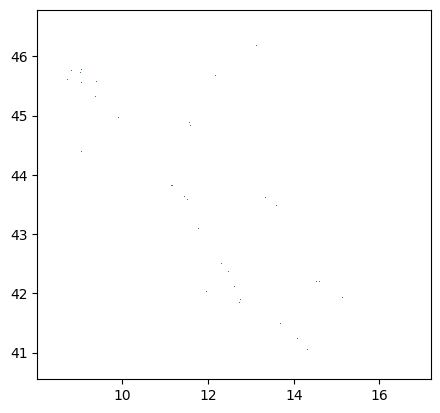

In [21]:
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np

def create_1km_grid(lat, lon):
    # Approximate km per degree
    km_in_degree = 0.5 / 110.574
    km_lon = 0.5 / (111.320 * np.cos(np.radians(lat)))
    
    # Define the square grid, approx 0.5km by 0.5km
    square = Polygon([
        (lon - km_lon, lat - km_in_degree),
        (lon - km_lon, lat + km_in_degree),
        (lon + km_lon, lat + km_in_degree),
        (lon + km_lon, lat - km_in_degree)
    ])
    return square

# Ensure correct DataFrame name and structure in zipping
gdf = gpd.GeoDataFrame(
    final_dataset,
    geometry=[create_1km_grid(lat, lon) for lat, lon in zip(final_dataset['gpsLat'], final_dataset['gpsLong'])],
    crs="EPSG:4326"  # Ensure it's in latitude and longitude
)

# visualize the grid
gdf.plot()

In [22]:
import geopandas as gpd
from shapely.geometry import Polygon

def create_1km_grid(lat, lon):
    """Creates a 0.5km x 0.5km square grid around a given point (latitude, longitude)."""
    # Approximate metrics for 0.5km at given latitude; adjust as necessary
    km_lat = 0.5 / 110.574  # degrees latitude per kilometer
    km_lon = 0.5 / (111.320 * np.cos(np.radians(lat)))  # degrees longitude per kilometer

    # Define the bounds of the square grid
    lat_min = lat - (km_lat / 2)
    lat_max = lat + (km_lat / 2)
    lon_min = lon - (km_lon / 2)
    lon_max = lon + (km_lon / 2)

    # Create a polygon
    square = Polygon([
        (lon_min, lat_min),
        (lon_min, lat_max),
        (lon_max, lat_max),
        (lon_max, lat_min),
        (lon_min, lat_min)
    ])
    return square

# Apply the function to each row in your DataFrame
final_dataset['polygon'] = final_dataset.apply(lambda x: create_1km_grid(x['gpsLat'], x['gpsLong']), axis=1)

# Convert final_dataset to a GeoDataFrame
gdf = gpd.GeoDataFrame(final_dataset, geometry='polygon', crs="EPSG:4326")

In [23]:
gdf.head()

,chargerId,gpsLat,gpsLong,average_current_all_months,polygon
0,6590.0,44.662290,10.857970,464.375510,"POLYGON ((10.85481 44.66003, 10.85481 44.66455..."
1,6708.0,42.499270,12.311060,419.504630,"POLYGON ((12.30801 42.49701, 12.30801 42.50153..."
2,6709.0,44.662290,10.858010,459.573484,"POLYGON ((10.85485 44.66003, 10.85485 44.66455..."
3,6710.0,42.499290,12.311070,472.371078,"POLYGON ((12.30802 42.49703, 12.30802 42.50155..."
4,6724.0,45.321012,9.375258,395.642547,"POLYGON ((9.37206 45.31875, 9.37206 45.32327, ..."


In [24]:
import geopandas as gpd
import osmnx as ox

# Fetch charging stations across Italy from OSM
charging_stations = ox.geometries_from_place('Italy', tags={'amenity': 'charging_station'})

# Ensure the CRS matches that of 'gdf'
charging_stations = charging_stations.to_crs(gdf.crs)

# Perform a spatial join to find charging stations within each grid
joined_data = gpd.sjoin(gdf, charging_stations, how='left', op='contains')

# Count the number of charging stations in each grid
gdf['EV_station_counts'] = joined_data.groupby(joined_data.index).size()

# Fill NaN values with 0 for grids without any charging stations
gdf['EV_station_counts'].fillna(0, inplace=True)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\3421728701.py:5: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  charging_stations = ox.geometries_from_place('Italy', tags={'amenity': 'charging_station'})
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 344 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

In [25]:
gdf.head()

,chargerId,gpsLat,gpsLong,average_current_all_months,polygon,EV_station_counts
0,6590.0,44.662290,10.857970,464.375510,"POLYGON ((10.85481 44.66003, 10.85481 44.66455...",1
1,6708.0,42.499270,12.311060,419.504630,"POLYGON ((12.30801 42.49701, 12.30801 42.50153...",1
2,6709.0,44.662290,10.858010,459.573484,"POLYGON ((10.85485 44.66003, 10.85485 44.66455...",1
3,6710.0,42.499290,12.311070,472.371078,"POLYGON ((12.30802 42.49703, 12.30802 42.50155...",1
4,6724.0,45.321012,9.375258,395.642547,"POLYGON ((9.37206 45.31875, 9.37206 45.32327, ...",1


In [26]:
# Load the population data
df_pop = pd.read_csv(r"D:\BIG_DATA\external_data\ita_general_2020.csv")

In [27]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import numpy as np

# Ensure the population data is a GeoDataFrame with Point geometry
if not isinstance(df_pop, gpd.GeoDataFrame):
    df_pop = gpd.GeoDataFrame(
        df_pop, 
        geometry=gpd.points_from_xy(df_pop.longitude, df_pop.latitude),
        crs='EPSG:4326'  # Ensure the coordinate reference system is longitude and latitude
    )

# If gdf needs to be set to the same CRS
df_pop = df_pop.to_crs(gdf.crs)

# Spatial join population points to grids
joined = gpd.sjoin(gdf, df_pop, how='left', op='contains')

# Group by grid index and calculate mean population for each grid
population = joined.groupby(joined.index).ita_general_2020.mean().fillna(0)

# Assign the calculated population density back to the grid DataFrame
gdf['population'] = population

# Handling NaN values, if there are any that did not match
gdf['population'] = gdf['population'].fillna(0)

C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [28]:
gdf.head()

,chargerId,gpsLat,gpsLong,average_current_all_months,polygon,EV_station_counts,population
0,6590.0,44.662290,10.857970,464.375510,"POLYGON ((10.85481 44.66003, 10.85481 44.66455...",1,0.090592
1,6708.0,42.499270,12.311060,419.504630,"POLYGON ((12.30801 42.49701, 12.30801 42.50153...",1,0.308648
2,6709.0,44.662290,10.858010,459.573484,"POLYGON ((10.85485 44.66003, 10.85485 44.66455...",1,0.090592
3,6710.0,42.499290,12.311070,472.371078,"POLYGON ((12.30802 42.49703, 12.30802 42.50155...",1,0.308648
4,6724.0,45.321012,9.375258,395.642547,"POLYGON ((9.37206 45.31875, 9.37206 45.32327, ...",1,0.095699


In [29]:
features = {
    'amenity': ['school', 'university', 'restaurant', 'place_of_worship', 
                'community_centre', 'townhall', 'parking', 'library'],
    'leisure': ['park', 'cinema'],
    'building': ['commercial', 'government', 'civic', 'retail']
}

In [30]:
import osmnx as ox
import geopandas as gpd

# Assuming 'gdf' is your GeoDataFrame with polygons
for feature_type, values in features.items():
    # Column for storing POI counts
    for value in values:
        gdf[f'{value}_count'] = 0  # initialize the count column

    for idx, row in gdf.iterrows():
        polygon = row['polygon']
        poi_count = {}

        for value in values:
            # Query for POIs within the polygon
            tags = {feature_type: value}
            try:
                pois = ox.geometries_from_polygon(polygon, tags)
                poi_count[value] = len(pois)
            except Exception as e:
                print(f"Error querying {value}: {str(e)}")
                poi_count[value] = 0  # Handle areas with no data

        # Update the counts in the dataframe
        for key, count in poi_count.items():
            gdf.loc[idx, f'{key}_count'] = count

# Ensure all data operations are complete
gdf = gdf.copy()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying university: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: F

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2793158167.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


In [31]:
gdf.head()

,chargerId,gpsLat,gpsLong,average_current_all_months,polygon,EV_station_counts,population,school_count,university_count,restaurant_count,...,community_centre_count,townhall_count,parking_count,library_count,park_count,cinema_count,commercial_count,government_count,civic_count,retail_count
0,6590.0,44.662290,10.857970,464.375510,"POLYGON ((10.85481 44.66003, 10.85481 44.66455...",1,0.090592,0,0,2,...,0,0,6,0,0,0,1,0,0,2
1,6708.0,42.499270,12.311060,419.504630,"POLYGON ((12.30801 42.49701, 12.30801 42.50153...",1,0.308648,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6709.0,44.662290,10.858010,459.573484,"POLYGON ((10.85485 44.66003, 10.85485 44.66455...",1,0.090592,0,0,2,...,0,0,6,0,0,0,1,0,0,2
3,6710.0,42.499290,12.311070,472.371078,"POLYGON ((12.30802 42.49703, 12.30802 42.50155...",1,0.308648,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6724.0,45.321012,9.375258,395.642547,"POLYGON ((9.37206 45.31875, 9.37206 45.32327, ...",1,0.095699,0,0,1,...,0,0,2,0,0,0,0,0,0,1


In [32]:
# Define the land use categories
categories = {
    'residential': ['residential'],
    'commercial': ['commercial', 'retail', 'office', 'industrial'],
    'retail': ['retail'],
    'industrial': ['industrial'],
    'other': ['agricultural', 'forest', 'conservation', 'recreation']
}

# Function to categorize land use
def categorize_landuse(landuse_gdf):
    # Initialize the category as 'Other'
    category = 'Other'
    if not landuse_gdf.empty:
        # Count occurrences of each landuse type
        counts = landuse_gdf['landuse'].value_counts()
        # Find the most frequent landuse category
        for cat, types in categories.items():
            if any(landuse in counts for landuse in types):
                category = cat
                break
    return category

# Create a new column for land use categories
gdf['landuse'] = 'Other'  # Initialize the column with 'Other'

# Iterate over each polygon in gdf to find land use
for idx, row in gdf.iterrows():
    try:
        # Extract land use within the polygon
        landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
        # Categorize land use and update the dataframe
        gdf.at[idx, 'landuse'] = categorize_landuse(landuse_gdf)
    except Exception as e:
        print(f"Failed to fetch or process land use data for index {idx}: {str(e)}")

# Check the resulting DataFrame
gdf[['polygon', 'landuse']].head()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 1: No data elements in server response. Check log and query location/tags.
Failed to fetch or process land use data for index 3: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 7: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 14: No data elements in server response. Check log and query location/tags.
Failed to fetch or process land use data for index 15: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 19: No data elements in server response. Check log and query location/tags.
Failed to fetch or process land use data for index 20: No data elements in server response. Check log and query location/tags.
Failed to fetch or process land use data for index 21: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 22: No data elements in server response. Check log and query location/tags.
Failed to fetch or process land use data for index 23: No data elements in server response. Check log and query location/tags.
Failed to fetch or process land use data for index 24: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 43: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 68: No data elements in server response. Check log and query location/tags.
Failed to fetch or process land use data for index 70: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 73: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 76: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 88: No data elements in server response. Check log and query location/tags.
Failed to fetch or process land use data for index 89: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 91: No data elements in server response. Check log and query location/tags.
Failed to fetch or process land use data for index 93: No data elements in server response. Check log and query location/tags.
Failed to fetch or process land use data for index 94: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 97: No data elements in server response. Check log and query location/tags.
Failed to fetch or process land use data for index 98: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 105: No data elements in server response. Check log and query location/tags.
Failed to fetch or process land use data for index 107: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 114: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 130: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 137: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 141: No data elements in server response. Check log and query location/tags.
Failed to fetch or process land use data for index 142: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 145: No data elements in server response. Check log and query location/tags.
Failed to fetch or process land use data for index 147: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 151: No data elements in server response. Check log and query location/tags.
Failed to fetch or process land use data for index 153: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 154: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 171: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 185: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 188: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 191: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 200: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

Failed to fetch or process land use data for index 207: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\4144539513.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Use

,polygon,landuse
0,"POLYGON ((10.85481 44.66003, 10.85481 44.66455...",residential
1,"POLYGON ((12.30801 42.49701, 12.30801 42.50153...",Other
2,"POLYGON ((10.85485 44.66003, 10.85485 44.66455...",residential
3,"POLYGON ((12.30802 42.49703, 12.30802 42.50155...",Other
4,"POLYGON ((9.37206 45.31875, 9.37206 45.32327, ...",Other


In [33]:
# Function to aggregate road data for a given polygon
def aggregate_road_data(polygon):
    # Define the tags for the road data we're interested in
    tags = {'highway': True}
    
    # Attempt to fetch road data within the polygon
    try:
        roads = ox.geometries_from_polygon(polygon, tags)
        if roads.empty:
            return 'No roads', None, None, None  # Return defaults if no roads found
        
        # Process 'oneway' status
        oneway = roads['oneway'].mode().iloc[0] if 'oneway' in roads else None
        
        # Process 'lanes' by finding the most common value
        lanes = roads['lanes'].mode().iloc[0] if 'lanes' in roads else None
        
        # Process 'highway' type
        highway = roads['highway'].mode().iloc[0] if 'highway' in roads else None
        
        # Process 'maxspeed' by converting to numeric and finding the mean
        if 'maxspeed' in roads:
            roads['maxspeed'] = pd.to_numeric(roads['maxspeed'].str.replace(' km/h', '', regex=False), errors='coerce')
            maxspeed = roads['maxspeed'].mean()
        else:
            maxspeed = None
            
        return oneway, lanes, highway, maxspeed

    except Exception as e:
        print(f"Failed to fetch or process road data: {str(e)}")
        return None, None, None, None  # Return None for all values in case of failure

# Initialize new columns
gdf['oneway_exists'] = None
gdf['average_lanes'] = None
gdf['high_way'] = None
gdf['average_maxspeed'] = None

# Iterate over each polygon to fetch and store road data
for idx, row in gdf.iterrows():
    oneway, lanes, highway, maxspeed = aggregate_road_data(row['polygon'])
    gdf.at[idx, 'oneway_exists'] = oneway
    gdf.at[idx, 'average_lanes'] = lanes
    gdf.at[idx, 'high_way'] = highway
    gdf.at[idx, 'average_maxspeed'] = maxspeed

# Check the resulting DataFrame
gdf[['polygon', 'oneway_exists', 'average_lanes', 'high_way', 'average_maxspeed']].head()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2066729028.py:8: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  roads = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2066729028.py:8: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  roads = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\2066729028.py:8: Fu

,polygon,oneway_exists,average_lanes,high_way,average_maxspeed
0,"POLYGON ((10.85481 44.66003, 10.85481 44.66455...",yes,4,service,94.0
1,"POLYGON ((12.30801 42.49701, 12.30801 42.50153...",yes,2,service,85.0
2,"POLYGON ((10.85485 44.66003, 10.85485 44.66455...",yes,4,service,94.0
3,"POLYGON ((12.30802 42.49703, 12.30802 42.50155...",yes,2,service,85.0
4,"POLYGON ((9.37206 45.31875, 9.37206 45.32327, ...",yes,3,service,130.0


In [34]:
import osmnx as ox
import networkx as nx
import geopandas as gpd

# Function to extract network data (node count, edge count, and road density) for a given polygon
def extract_network_data(polygon):
    try:
        # Create network from polygon
        G = ox.graph_from_polygon(polygon, network_type='drive', simplify=True)

        # Convert the graph to a GeoDataFrame
        nodes, edges = ox.graph_to_gdfs(G)

        # Count nodes and edges
        nodes = len(nodes)
        edges = len(edges)

        # Calculate graph density
        density = nx.density(G)

        return nodes, edges, density

    except Exception as e:
        print(f"Failed to create network or calculate metrics: {str(e)}")
        return 0, 0, 0  # Return 0 for all metrics in case of failure

# Initialize new columns for node count, edge count, and road density
gdf['nodes'] = 0
gdf['edges'] = 0
gdf['density'] = 0

# Iterate over each polygon to fetch and store network data
for idx, row in gdf.iterrows():
    nodes, edges, density = extract_network_data(row['polygon'])
    gdf.at[idx, 'nodes'] = nodes
    gdf.at[idx, 'edges'] = edges
    gdf.at[idx, 'density'] = density

Failed to create network or calculate metrics: Connectivity is undefined for the null graph.
Failed to create network or calculate metrics: Found no graph nodes within the requested polygon
Failed to create network or calculate metrics: Connectivity is undefined for the null graph.
Failed to create network or calculate metrics: Found no graph nodes within the requested polygon


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\856387270.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  gdf.at[idx, 'density'] = density


Failed to create network or calculate metrics: Found no graph nodes within the requested polygon
Failed to create network or calculate metrics: Connectivity is undefined for the null graph.
Failed to create network or calculate metrics: Connectivity is undefined for the null graph.
Failed to create network or calculate metrics: Connectivity is undefined for the null graph.
Failed to create network or calculate metrics: Found no graph nodes within the requested polygon
Failed to create network or calculate metrics: Found no graph nodes within the requested polygon
Failed to create network or calculate metrics: Connectivity is undefined for the null graph.
Failed to create network or calculate metrics: Connectivity is undefined for the null graph.
Failed to create network or calculate metrics: Connectivity is undefined for the null graph.
Failed to create network or calculate metrics: Connectivity is undefined for the null graph.
Failed to create network or calculate metrics: Found no gr

In [35]:
gdf.head()

,chargerId,gpsLat,gpsLong,average_current_all_months,polygon,EV_station_counts,population,school_count,university_count,restaurant_count,...,civic_count,retail_count,landuse,oneway_exists,average_lanes,high_way,average_maxspeed,nodes,edges,density
0,6590.0,44.662290,10.857970,464.375510,"POLYGON ((10.85481 44.66003, 10.85481 44.66455...",1,0.090592,0,0,2,...,0,2,residential,yes,4,service,94.0,0,0,0.0
1,6708.0,42.499270,12.311060,419.504630,"POLYGON ((12.30801 42.49701, 12.30801 42.50153...",1,0.308648,0,0,0,...,0,0,Other,yes,2,service,85.0,0,0,0.0
2,6709.0,44.662290,10.858010,459.573484,"POLYGON ((10.85485 44.66003, 10.85485 44.66455...",1,0.090592,0,0,2,...,0,2,residential,yes,4,service,94.0,0,0,0.0
3,6710.0,42.499290,12.311070,472.371078,"POLYGON ((12.30802 42.49703, 12.30802 42.50155...",1,0.308648,0,0,0,...,0,0,Other,yes,2,service,85.0,0,0,0.0
4,6724.0,45.321012,9.375258,395.642547,"POLYGON ((9.37206 45.31875, 9.37206 45.32327, ...",1,0.095699,0,0,1,...,0,1,Other,yes,3,service,130.0,5,8,0.4


In [36]:
gdf.dtypes

chargerId                      float64
gpsLat                         float64
gpsLong                        float64
average_current_all_months     float64
polygon                       geometry
EV_station_counts                int64
population                     float64
school_count                     int64
university_count                 int64
restaurant_count                 int64
place_of_worship_count           int64
community_centre_count           int64
townhall_count                   int64
parking_count                    int64
library_count                    int64
park_count                       int64
cinema_count                     int64
commercial_count                 int64
government_count                 int64
civic_count                      int64
retail_count                     int64
landuse                         object
oneway_exists                   object
average_lanes                   object
high_way                        object
average_maxspeed         

In [37]:
gdf.to_csv(r"D:\BIG_DATA\charging_stations\task_2\optimise_task2_final.csv")

In [38]:
gdf = pd.read_csv(r"D:\BIG_DATA\charging_stations\task_2\optimise_task2_final.csv")

# Predict Average energy per month

In [39]:
gdf.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,220.0,109.500000,63.652704,0.000000,54.750000,109.500000,164.250000,219.000000
chargerId,220.0,20604.740909,20228.590854,6590.000000,9918.750000,16937.500000,19527.250000,83836.000000
gpsLat,220.0,43.756481,1.600397,40.837697,42.203072,44.379278,45.074638,46.499058
gpsLong,220.0,11.657192,2.179045,8.441120,9.393805,11.582400,13.223313,16.777855
average_current_all_months,220.0,445.247358,66.900971,0.000000,424.076955,446.180599,470.066516,799.000000
EV_station_counts,220.0,1.395455,0.628819,1.000000,1.000000,1.000000,2.000000,4.000000
population,220.0,1.010814,1.758941,0.000000,0.071482,0.304533,0.988935,10.867543
school_count,220.0,0.031818,0.241544,0.000000,0.000000,0.000000,0.000000,3.000000
university_count,220.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
restaurant_count,220.0,1.068182,1.621738,0.000000,0.000000,1.000000,2.000000,11.000000


In [40]:
# Check for missing values
gdf.isnull().sum()

Unnamed: 0                     0
chargerId                      0
gpsLat                         0
gpsLong                        0
average_current_all_months     0
polygon                        0
EV_station_counts              0
population                     0
school_count                   0
university_count               0
restaurant_count               0
place_of_worship_count         0
community_centre_count         0
townhall_count                 0
parking_count                  0
library_count                  0
park_count                     0
cinema_count                   0
commercial_count               0
government_count               0
civic_count                    0
retail_count                   0
landuse                        0
oneway_exists                 10
average_lanes                  4
high_way                       0
average_maxspeed              11
nodes                          0
edges                          0
density                        0
dtype: int

In [41]:
# Dropping the specified features
gdf = gdf.drop(columns=['gpsLat', 'gpsLong', 'polygon'])

In [42]:
gdf['oneway_exists'].fillna('No', inplace=True)
gdf['average_lanes'].fillna(0, inplace=True)
mean_speed = gdf['average_maxspeed'].mean()
gdf['average_maxspeed'].fillna(mean_speed, inplace=True)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\1635041965.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf['oneway_exists'].fillna('No', inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15084\1635041965.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [43]:
# Check for missing values
gdf.isnull().sum()

Unnamed: 0                    0
chargerId                     0
average_current_all_months    0
EV_station_counts             0
population                    0
school_count                  0
university_count              0
restaurant_count              0
place_of_worship_count        0
community_centre_count        0
townhall_count                0
parking_count                 0
library_count                 0
park_count                    0
cinema_count                  0
commercial_count              0
government_count              0
civic_count                   0
retail_count                  0
landuse                       0
oneway_exists                 0
average_lanes                 0
high_way                      0
average_maxspeed              0
nodes                         0
edges                         0
density                       0
dtype: int64

In [44]:
gdf.dtypes

Unnamed: 0                      int64
chargerId                     float64
average_current_all_months    float64
EV_station_counts               int64
population                    float64
school_count                    int64
university_count                int64
restaurant_count                int64
place_of_worship_count          int64
community_centre_count          int64
townhall_count                  int64
parking_count                   int64
library_count                   int64
park_count                      int64
cinema_count                    int64
commercial_count                int64
government_count                int64
civic_count                     int64
retail_count                    int64
landuse                        object
oneway_exists                  object
average_lanes                 float64
high_way                       object
average_maxspeed              float64
nodes                           int64
edges                           int64
density     

In [45]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Splitting the data into train+validation and test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    gdf.drop(columns=['average_current_all_months', 'Unnamed: 0', 'chargerId']), 
    gdf['average_current_all_months'], 
    test_size=0.2, 
    random_state=23
)

In [47]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define categorical and numerical features
categorical_features = ['landuse', 'oneway_exists', 'high_way']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

# Creating a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Fitting the preprocessor on the training data and transforming training data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [48]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import clone

In [49]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Machine': SVR()
}

In [50]:
# Define KFold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=23)

# Cross-validation and model evaluation
results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    cv_scores = cross_val_score(pipeline, X_train, Y_train, cv=kf, scoring='neg_mean_squared_error')
    results[name] = np.sqrt(-cv_scores)  # Convert MSE to RMSE

# Display the RMSE results for each model
for name, scores in results.items():
    print(f"{name}: Mean RMSE = {np.mean(scores):.3f} +/- {np.std(scores):.3f}")

# Select the best model based on RMSE
best_model_name = min(results, key=lambda x: np.mean(results[x]))
best_model = models[best_model_name]

# Retrain the best model on the full training data
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', best_model)
])
final_pipeline.fit(X_train, Y_train)

# Evaluate on the test set
y_pred = final_pipeline.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
print(f"Test RMSE: {test_rmse:.3f}")
print(f"Best model: {best_model_name}")

Linear Regression: Mean RMSE = 85.612 +/- 15.866
Ridge Regression: Mean RMSE = 70.481 +/- 20.729
Lasso Regression: Mean RMSE = 68.668 +/- 21.727
Random Forest: Mean RMSE = 82.875 +/- 25.019
Gradient Boosting: Mean RMSE = 92.414 +/- 30.159
Support Vector Machine: Mean RMSE = 64.988 +/- 23.409
Test RMSE: 57.020
Best model: Support Vector Machine


## Retrain the best model on the whole dataset

In [51]:
X, Y = gdf.drop(columns=['average_current_all_months', 'Unnamed: 0', 'chargerId']), gdf['average_current_all_months']

In [52]:
import joblib

# Define categorical and numerical features
categorical_features = ['landuse', 'oneway_exists', 'high_way']
numerical_features = [col for col in X.columns if col not in categorical_features]

# Create a column transformer with OneHotEncoder handling unknown categories
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create a pipeline with preprocessing and SVR regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

# Train the pipeline on the whole data
pipeline.fit(X, Y)

# Save the pipeline to disk
joblib.dump(pipeline, r'D:\BIG_DATA\charging_stations\task_2\svm_model.pkl')
print("Model and preprocessor saved successfully!")

Model and preprocessor saved successfully!


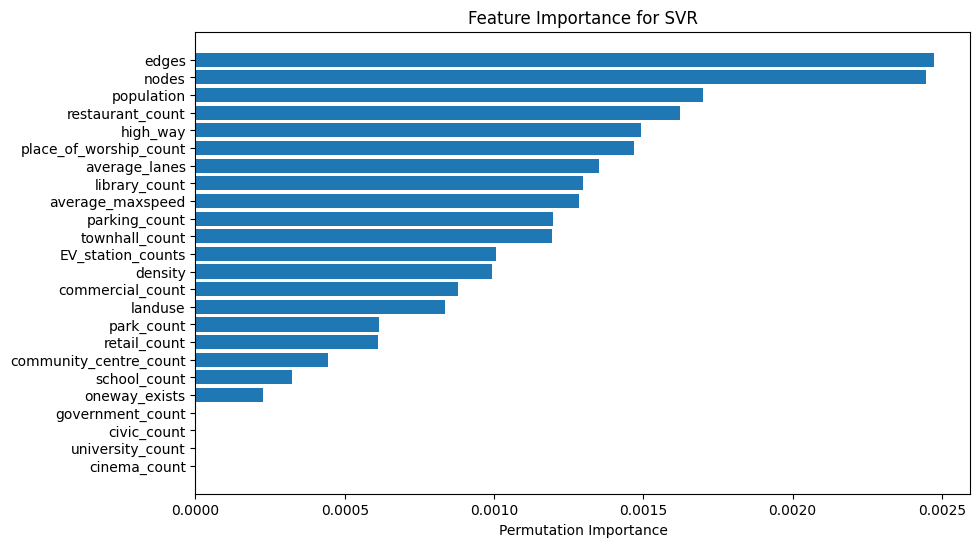

In [53]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Calculate permutation importance
result = permutation_importance(pipeline, X, Y, n_repeats=10, random_state=23)
importance = result.importances_mean

# Plot feature importance
indices = np.argsort(importance)
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importance[indices], align="center")
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance for SVR")
plt.show()

In [ ]:
# Load the pipeline
#loaded_pipeline = joblib.load(r'D:\BIG_DATA\charging_stations\task_2\svm_model.pkl')

# 'new_data'
#predictions = loaded_pipeline.predict(new_data)
#print("Predictions:", predictions)